[#242](https://github.com/chengsoonong/crowdastro/issues/242)

In [129]:
# Some setup.
import h5py, numpy, matplotlib.pyplot as plt, astropy.io.ascii as asc, scipy.spatial, sklearn.model_selection
import crowdastro.crowd.util, sklearn.linear_model, sklearn.ensemble, astropy.table, collections
%matplotlib inline

In [173]:
with h5py.File('/Users/alger/data/Crowdastro/swire.h5', 'r') as f:
    swire_features = f['features'].value
with h5py.File('/Users/alger/data/Crowdastro/crowdastro-swire.h5', 'r') as f:
    swire_coords = f['/swire/cdfs/numeric'][:, :2]
    swire_names = [i.decode('ascii') for i in f['/swire/cdfs/string'].value]
table = asc.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')
swire_tree = scipy.spatial.KDTree(swire_coords)
labels = asc.read('/Users/alger/data/SWIRE/all_labels.csv')
atlas_coords = numpy.array([(r['Component RA (Franzen)'], r['Component DEC (Franzen)']) for r in table
                            if r['Component RA (Franzen)']])
rgz_catalogue = asc.read('/Users/alger/data/ATLAS/static_rgz_host_full.csv')

## Generate training sets

We are looking for five different training sets for each subset of the ATLAS-CDFS data:

- RGZ & Norris & compact (the "clean" set)
- RGZ & Norris & resolved
- RGZ & Norris
- RGZ compact
- RGZ resolved
- RGZ

First, let's have a function that takes a set of ATLAS objects and returns five sets of SWIRE objects.

In [10]:
def atlas_to_swire(atlas: list, radius: float=1 / 60) -> list:
    # atlas is a list of table Keys.
    # Look up the coordinates of the ATLAS objects.
    atlas = set(atlas)
    ras = [r['Component RA (Franzen)'] for r in table if r['Key'] in atlas]
    decs = [r['Component DEC (Franzen)'] for r in table if r['Key'] in atlas]
    coords = numpy.vstack([ras, decs]).T
    nearby = sorted({int(i)
                     for i in numpy.concatenate(swire_tree.query_ball_point(coords, radius))})
    return nearby

Next, we'll split ATLAS into three (overlapping) subsets:

- RGZ
- Norris
- Compact

From these we can compute all subsets we want to train on.

In [11]:
rgz = {r['Key'] for r in table if r['Component Zooniverse ID (RGZ)'] and
                                         r['Component ID (Franzen)'] == r['Primary Component ID (RGZ)'] and
                                  r['Component ID (Franzen)']}
norris = {r['Key'] for r in table if r['Component # (Norris)'] and r['Component ID (Franzen)']}
compact = {r['Key'] for r in table if r['Component ID (Franzen)'] and
                                             r['Component S (Franzen)'] / r['Component Sp (Franzen)'] <= 1}

We can now compute the training sets. We will split CDFS in four. Let's start by finding the min/max RA/dec to get our dividing lines.

In [12]:
middle = (numpy.median(atlas_coords[:, 0]), numpy.median(atlas_coords[:, 1]))
middle = (52.8, -28.1)

In [13]:
subsets = [
    ('RGZ & Norris & compact', rgz & norris & compact),
    ('RGZ & Norris & resolved', rgz & norris - compact),
    ('RGZ & Norris', rgz & norris),
    ('RGZ & compact', rgz & compact),
    ('RGZ & resolved', rgz - compact),
    ('RGZ', rgz),
]

In [14]:
training_testing_atlas_sets = {s:[] for s, _ in subsets}  # Maps subset string -> [(train, test)]

def filter_subset(subset: set, q: int) -> set:
    """Filters subset to just include indices of ATLAS objects in a given quadrant."""
    subset_ = set()
    for s in subset:
        row = table[table['Key'] == s][0]
        coords = row['Component RA (Franzen)'], row['Component DEC (Franzen)']

        if (
                (q == 0 and coords[0] >= middle[0] and coords[1] >= middle[1]) or
                (q == 1 and coords[0] < middle[0] and coords[1] >= middle[1]) or
                (q == 2 and coords[0] < middle[0] and coords[1] < middle[1]) or
                (q == 3 and coords[0] >= middle[0] and coords[1] < middle[1])):
            subset_.add(s)
    return subset_

for subset_str, subset_set in subsets:
    for q in range(4):  # Quadrants.
        test = filter_subset(subset_set, q)
        train = {i for i in subset_set if i not in test}
        print(subset_str, len(train), len(test))
        training_testing_atlas_sets[subset_str].append((train, test))

RGZ & Norris & compact 244 143
RGZ & Norris & compact 294 93
RGZ & Norris & compact 329 58
RGZ & Norris & compact 294 93
RGZ & Norris & resolved 123 35
RGZ & Norris & resolved 113 45
RGZ & Norris & resolved 120 38
RGZ & Norris & resolved 118 40
RGZ & Norris 367 178
RGZ & Norris 407 138
RGZ & Norris 449 96
RGZ & Norris 412 133
RGZ & compact 1786 398
RGZ & compact 1547 637
RGZ & compact 1642 542
RGZ & compact 1577 607
RGZ & resolved 221 55
RGZ & resolved 200 76
RGZ & resolved 206 70
RGZ & resolved 201 75
RGZ 2007 453
RGZ 1747 713
RGZ 1848 612
RGZ 1778 682


These can be converted into SWIRE sets.

In [16]:
training_testing_swire_sets = {s:[] for s, _ in subsets}  # Maps subset string -> [(train, test)]

for subset_str, subset_set in subsets:
    for train, test in training_testing_atlas_sets[subset_str]:
        train = atlas_to_swire(train)
        test = atlas_to_swire(test)
        print(subset_str, len(set(train) & set(test)), 'out of', len(set(test)), 'overlap')
        train = sorted(set(train) - set(test))
        training_testing_swire_sets[subset_str].append((train, test))

RGZ & Norris & compact 0 out of 3064 overlap
RGZ & Norris & compact 0 out of 2154 overlap
RGZ & Norris & compact 15 out of 1468 overlap
RGZ & Norris & compact 15 out of 2152 overlap
RGZ & Norris & resolved 0 out of 927 overlap
RGZ & Norris & resolved 0 out of 1079 overlap
RGZ & Norris & resolved 0 out of 1074 overlap
RGZ & Norris & resolved 0 out of 1075 overlap
RGZ & Norris 0 out of 3880 overlap
RGZ & Norris 8 out of 3110 overlap
RGZ & Norris 23 out of 2435 overlap
RGZ & Norris 15 out of 3107 overlap
RGZ & compact 33 out of 7301 overlap
RGZ & compact 84 out of 10877 overlap
RGZ & compact 129 out of 9123 overlap
RGZ & compact 78 out of 10897 overlap
RGZ & resolved 0 out of 1414 overlap
RGZ & resolved 0 out of 1760 overlap
RGZ & resolved 0 out of 1804 overlap
RGZ & resolved 0 out of 1900 overlap
RGZ 65 out of 8317 overlap
RGZ 143 out of 11913 overlap
RGZ 188 out of 10299 overlap
RGZ 110 out of 11976 overlap


## Extracting labels

In [20]:
swire_name_to_rgz_label = {}
swire_name_to_norris_label = {}
for row in labels:
    swire_name_to_norris_label[row['swire']] = bool(row['norris_label']) and row['norris_label'] == 'True'
    swire_name_to_rgz_label[row['swire']] = bool(row['rgz_label']) and row['rgz_label'] == 'True'

## Training LR with Norris labels

We will now train logistic regression on the Norris label set. We will test on both RGZ and Norris, since there are objects that RGZ observes that Norris does not.

In [124]:
def test_on_sets(training_testing_swire_sets, name_to_label, Classifier):
    for subset_str, splits in training_testing_swire_sets.items():
        if 'Norris' not in subset_str:
            continue

        rgz_accuracies = []
        norris_accuracies = []
        predictions = []
        for train, test in splits:
            train_features = swire_features[train]
            train_labels = [name_to_label[swire_names[i]] for i in train]

            test_features = swire_features[test]

            lr = Classifier()
            lr.fit(train_features, train_labels)
            
            preds = lr.predict(test_features)
            predictions.append(dict(zip([swire_names[i] for i in test], lr.predict_proba(test_features))))

            if 'Norris' in subset_str:
                test_labels_norris = [swire_name_to_norris_label[swire_names[i]] for i in test]
                norris_accuracies.append(
                    crowdastro.crowd.util.balanced_accuracy(test_labels_norris, preds))
            test_labels_rgz = [swire_name_to_rgz_label[swire_names[i]] for i in test]
            rgz_accuracies.append(
                crowdastro.crowd.util.balanced_accuracy(test_labels_rgz, preds))
        yield subset_str, (rgz_accuracies, norris_accuracies), predictions

In [125]:
norris_lr_results = list(test_on_sets(
        training_testing_swire_sets, swire_name_to_norris_label,
        lambda: sklearn.linear_model.LogisticRegression(class_weight='balanced', penalty='l2', C=1e10)))
for subset, (rgz_acc, norris_acc), _ in norris_lr_results:
    print('{} on RGZ: ({:.02f} +- {:.02f})%'.format(
        subset, numpy.mean(rgz_acc) * 100, numpy.std(rgz_acc) * 100))
    print('{} on Norris: ({:.02f} +- {:.02f})%'.format(
        subset, numpy.mean(norris_acc) * 100, numpy.std(norris_acc) * 100))

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


RGZ & Norris & compact on RGZ: (77.63 +- 2.10)%
RGZ & Norris & compact on Norris: (94.74 +- 1.40)%
RGZ & Norris & resolved on RGZ: (82.43 +- 2.09)%
RGZ & Norris & resolved on Norris: (89.85 +- 1.65)%
RGZ & Norris on RGZ: (84.44 +- 0.62)%
RGZ & Norris on Norris: (94.44 +- 1.46)%


## Training RF with Norris labels

In [126]:
norris_rf_results = list(test_on_sets(
        training_testing_swire_sets, swire_name_to_norris_label,
        lambda: sklearn.ensemble.RandomForestClassifier(class_weight='balanced')))

for subset, (rgz_acc, norris_acc), _ in norris_rf_results:
    print('{} on RGZ: ({:.02f} +- {:.02f})%'.format(
        subset, numpy.mean(rgz_acc) * 100, numpy.std(rgz_acc) * 100))
    print('{} on Norris: ({:.02f} +- {:.02f})%'.format(
        subset, numpy.mean(norris_acc) * 100, numpy.std(norris_acc) * 100))

RGZ & Norris & compact on RGZ: (70.73 +- 2.78)%
RGZ & Norris & compact on Norris: (87.68 +- 6.69)%
RGZ & Norris & resolved on RGZ: (67.35 +- 3.18)%
RGZ & Norris & resolved on Norris: (80.42 +- 5.62)%
RGZ & Norris on RGZ: (70.95 +- 2.45)%
RGZ & Norris on Norris: (86.49 +- 5.82)%


## Training LR with RGZ labels

In [127]:
rgz_lr_results = list(test_on_sets(
        training_testing_swire_sets, swire_name_to_rgz_label,
        lambda: sklearn.linear_model.LogisticRegression(class_weight='balanced', penalty='l2', C=1e10)))
for subset, (rgz_acc, norris_acc), _ in rgz_lr_results:
    print('{} on RGZ: ({:.02f} +- {:.02f})%'.format(
        subset, numpy.mean(rgz_acc) * 100, numpy.std(rgz_acc) * 100))
    print('{} on Norris: ({:.02f} +- {:.02f})%'.format(
        subset, numpy.mean(norris_acc) * 100, numpy.std(norris_acc) * 100))

RGZ & Norris & compact on RGZ: (86.95 +- 1.28)%
RGZ & Norris & compact on Norris: (95.07 +- 0.68)%
RGZ & Norris & resolved on RGZ: (81.74 +- 1.37)%
RGZ & Norris & resolved on Norris: (87.84 +- 4.50)%
RGZ & Norris on RGZ: (84.19 +- 0.42)%
RGZ & Norris on Norris: (91.94 +- 1.09)%


## Training RF with RGZ labels

In [128]:
rgz_rf_results = list(test_on_sets(
        training_testing_swire_sets, swire_name_to_rgz_label,
        lambda: sklearn.ensemble.RandomForestClassifier(class_weight='balanced')))
for subset, (rgz_acc, norris_acc), _ in rgz_rf_results:
    print('{} on RGZ: ({:.02f} +- {:.02f})%'.format(
        subset, numpy.mean(rgz_acc) * 100, numpy.std(rgz_acc) * 100))
    print('{} on Norris: ({:.02f} +- {:.02f})%'.format(
        subset, numpy.mean(norris_acc) * 100, numpy.std(norris_acc) * 100))

RGZ & Norris & compact on RGZ: (80.11 +- 4.50)%
RGZ & Norris & compact on Norris: (90.06 +- 4.86)%
RGZ & Norris & resolved on RGZ: (71.20 +- 7.32)%
RGZ & Norris & resolved on Norris: (77.40 +- 12.52)%
RGZ & Norris on RGZ: (79.31 +- 4.16)%
RGZ & Norris on Norris: (87.96 +- 6.17)%


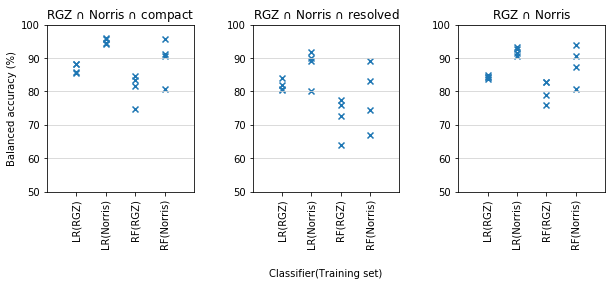

In [103]:
plt.figure(figsize=(10, 4))
for i, (subset_str, _) in enumerate(subsets[:3]):
    plt.subplot(1, 3, i + 1)
    plt.title(subset_str.replace('&', '$\\cap$'))
    plt.xticks([0, 1, 2, 3], ['LR(RGZ)', 'LR(Norris)', 'RF(RGZ)', 'RF(Norris)'], rotation='vertical')
    plt.grid(axis='y', which='major', color='lightgrey', linestyle='-')
    plt.ylim((50, 100))
    plt.xlim((-1, 4))
    
    if i == 1:
        plt.xlabel('Classifier(Training set)', labelpad=20)
    if i == 0:
        plt.ylabel('Balanced accuracy (%)')

    lr_rgz_acc, lr_norris_acc = [numpy.array(res) * 100 for sstr, res, _ in rgz_lr_results if sstr == subset_str][0]
    rf_rgz_acc, rf_norris_acc = [numpy.array(res) * 100 for sstr, res, _ in rgz_rf_results if sstr == subset_str][0]
    xs = [i for j in range(4) for i in [j] * 4]
    ys = list(lr_rgz_acc) + list(lr_norris_acc) + list(rf_rgz_acc) + list(rf_norris_acc)
    plt.scatter(xs, ys, marker='x')
plt.subplots_adjust(wspace=0.4, bottom=0.3)
plt.savefig('/Users/alger/Documents/writing/atlas-ml-ba.pdf')
plt.show()

## Table of predictions

We now want to generate a table of predictions. We will first generate a table of SWIRE-based predictions. Each SWIRE object will be assigned a label from each of two classifiers:

- LR(Norris)
- LR(RGZ)

These are trained on all data points in the training set, i.e., not splitting on compact/resolved. We report the labels from when the given SWIRE object was in a testing quadrant.

In [130]:
swire_name_to_rgz_lr_pred = collections.defaultdict(list)
swire_name_to_norris_lr_pred = collections.defaultdict(list)

for subset_str, _, preds in rgz_lr_results:
    for preds_ in preds:
        for name, pred in preds_.items():
            swire_name_to_rgz_lr_pred[name].append(pred)

for subset_str, _, preds in norris_lr_results:
    for preds_ in preds:
        for name, pred in preds_.items():
            swire_name_to_norris_lr_pred[name].append(pred)

In [145]:
import astropy.table
names_ = []
rgz_preds_ = []
norris_preds_ = []
for name in swire_names:
    if name not in swire_name_to_rgz_lr_pred:
        continue

    names_.append(name)
    rgz_ = numpy.mean([i[1] for i in swire_name_to_rgz_lr_pred[name]])
    norris_ = numpy.mean([i[1] for i in swire_name_to_norris_lr_pred[name]])
    rgz_preds_.append(rgz_)
    norris_preds_.append(norris_)
predicted_swire_table = astropy.table.Table(data=[names_, rgz_preds_, norris_preds_],
                                            names=['swire', 'lr(rgz)', 'lr(norris)'])
predicted_swire_table.write('/Users/alger/data/Crowdastro/predicted_swire_table.csv', format='csv')
predicted_swire_table.write('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/predicted_swire_table.tex',
                            format='latex')
predicted_swire_table

swire,lr(rgz),lr(norris)
str26,float64,float64
SWIRE3_J032559.15-284724.2,0.0341784863105,0.015480243078
SWIRE3_J032559.91-284728.9,0.278541709304,0.020090942017
SWIRE3_J032600.02-284736.9,0.245365593177,0.014413236572
SWIRE3_J032600.13-284637.5,0.0813282413296,0.0208829692218
SWIRE3_J032600.13-284715.7,0.387394784166,0.0343210418749
SWIRE3_J032600.98-284705.4,0.145593835335,0.0658117444017
SWIRE3_J032601.03-284711.6,0.677611173993,0.131620806718
SWIRE3_J032601.75-284614.5,0.134551589362,0.0131522724495
SWIRE3_J032602.08-284713.1,0.741262952211,0.565229482364


## Table of cross-identifications

Finally, we want to map these predictions back to the original task. Given an ATLAS object, get all SWIRE objects within 1' of that object. The highest probability host is then named as the host galaxy.

In [182]:
# Map Zooniverse ID -> [SWIRE from RGZ]
zid_to_rgz_consensus_swires = collections.defaultdict(list)
zid_to_rgz_consensus_radio = {}
zid_to_rgz_consensus_ir = collections.defaultdict(list)
for row in rgz_catalogue:
    zid_to_rgz_consensus_swires[row['zooniverse_id']].append(row['SWIRE.designation'])
    zid_to_rgz_consensus_ir[row['zooniverse_id']].append(row['consensus.ir_level'])
    zid_to_rgz_consensus_radio[row['zooniverse_id']] = row['consensus.radio_level']

In [192]:
zids_ = []
ras_ = []
decs_ = []
rgz_names_ = []
norris_names_ = []
rgz_consensuses_radio_level_ = []
rgz_consensuses_ir_level_ = []
rgz_consensuses_ = []
for row in table:
    if row['Key'] in rgz & norris:
        zid = row['Component Zooniverse ID (RGZ)']
        ra = row['Component RA (Franzen)']
        dec = row['Component DEC (Franzen)']
        nearby = swire_tree.query_ball_point([ra, dec], 1 / 60)
        names = [swire_names[i] for i in nearby]
        if not names:
            print('{} not found'.format(zid))
            continue
        norris_probs = [numpy.mean([i[1] for i in swire_name_to_norris_lr_pred[name]]) for name in names]
        norris_name = names[numpy.argmax(norris_probs)]
        rgz_probs = [numpy.mean([i[1] for i in swire_name_to_rgz_lr_pred[name]]) for name in names]
        rgz_name = names[numpy.argmax(rgz_probs)]
        zids_.append(zid)
        ras_.append(ra)
        decs_.append(dec)
        rgz_names_.append(rgz_name)
        norris_names_.append(norris_name)
        rgz_consensuses_.append(','.join(i for i in zid_to_rgz_consensus_swires.get(zid, [])))
        rgz_consensuses_radio_level_.append(zid_to_rgz_consensus_radio.get(zid))
        rgz_consensuses_ir_level_.append(','.join(str(i) for i in zid_to_rgz_consensus_ir.get(zid, [])))
cross_id_table = astropy.table.Table(data=[zids_, ras_, decs_, rgz_names_, norris_names_,
                                           rgz_consensuses_, rgz_consensuses_radio_level_, rgz_consensuses_ir_level_],
                                     names=['zooniverse_id', 'ra', 'dec', 'lr(rgz)_swire', 'lr(norris)_swire',
                                            'rgz_swire', 'rgz_consensus_radio_level', 'rgz_consensus_ir_level'])
cross_id_table.write('/Users/alger/data/Crowdastro/predicted_cross_ids_table.csv', format='csv')
cross_id_table.write('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/predicted_cross_ids_table.tex', format='latex')
cross_id_table

ARG0003spl not found


zooniverse_id,ra,dec,lr(rgz)_swire,lr(norris)_swire,rgz_swire,rgz_consensus_radio_level,rgz_consensus_ir_level
str10,float64,float64,str26,str26,str188,object,str74
ARG0003rb2,51.511734,-28.785575,SWIRE3_J032602.36-284711.5,SWIRE3_J032602.36-284711.5,-99,0.4,0.333333333333
ARG0003rfr,51.564555,-28.774847,SWIRE3_J032615.41-284630.7,SWIRE3_J032615.41-284630.7,"SWIRE3_J032616.14-284552.9,SWIRE3_J032615.41-284630.7",0.3125,"1.0,1.0"
ARG0003r8s,51.564799,-28.099955,SWIRE3_J032615.52-280559.8,SWIRE3_J032615.52-280559.8,"SWIRE3_J032616.71-280538.6,SWIRE3_J032617.94-280648.2,SWIRE3_J032615.52-280559.8",0.484848484848,"0.75,0.555555555556,0.8125"
ARG0003r2j,51.572279,-28.119491,SWIRE3_J032615.86-280628.8,SWIRE3_J032617.02-280638.9,SWIRE3_J032617.89-280707.2,0.421052631579,1.0
ARG0003raz,51.604711,-28.152731,SWIRE3_J032625.19-280910.1,SWIRE3_J032625.19-280910.1,SWIRE3_J032624.80-280915.9,0.3,0.333333333333
ARG0003ro4,51.621251,-28.113924,SWIRE3_J032629.13-280650.7,SWIRE3_J032629.13-280650.7,"SWIRE3_J032629.13-280650.7,SWIRE3_J032626.74-280636.7",0.357142857143,"0.8,1.0"
ARG0003r8e,51.623385,-28.681315,SWIRE3_J032629.54-284051.9,SWIRE3_J032629.54-284051.9,SWIRE3_J032629.54-284055.8,0.3,1.0
ARG0003r3w,51.624653,-28.798195,SWIRE3_J032629.81-284754.4,SWIRE3_J032629.81-284754.4,SWIRE3_J032629.81-284754.4,1.0,0.666666666667
ARG0003r55,51.62777,-28.615917,SWIRE3_J032630.64-283658.0,SWIRE3_J032630.64-283658.0,"SWIRE3_J032630.64-283658.0,SWIRE3_J032628.56-283744.8",0.354838709677,"1.0,0.727272727273"


## Export

Finally, let's export all our ATLAS and SWIRE sets.

In [198]:
import pickle

with open('/Users/alger/data/Crowdastro/sets_atlas.pkl', 'wb') as f:
    pickle.dump(training_testing_atlas_sets, f)

with open('/Users/alger/data/Crowdastro/sets_swire.pkl', 'wb') as f:
    pickle.dump(training_testing_swire_sets, f)